In [1]:
# Librerías que usamos
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint, LinearConstraint, Bounds

### Modelo a ajustar aquí

Solo patada en los medios:

$$ \dot m = - p m + \alpha b_{\tau} $$

$$ \dot b = -q b + r m + k b b_{\tau}$$

donde $b_{\tau} = b(t - \tau)$ que puede ser reemplazada por un conjunto finito de ecuaciones diferenciales ordinarias que simulen una distribución de delays.


In [2]:
def integrate_model(args, tmax, x0):

    p, alpha, q, r, k, tau = args
    tt = np.arange(0, tmax, 0.01)

    def model(x, t, p, alpha, q, r, k, tau):

            n = len(x)
            fs = np.zeros(n)

            fs[0] = - p * x[0] + alpha * x[-1]
            fs[1] = - q * x[1] + r * x[0] + k * x[1] * x[-1]
            for i in range(2, n):
                fs[i] = ((n-2)/tau) * (x[i-1] - x[i])

            return fs

    # Integración numérica del modelo
    yint = odeint(model, x0, tt, args=(p, alpha, q, r, k, tau), full_output=0)

    return tt, yint

### Initial guess

In [98]:
# Fileid of the series to analyze
id = 1401958
id =2146683
#id = 2163357
id= 14046


id = 810174 #doble byump
#id = 41933 #ambos bumps
#id = 700464 #bump mediso
#id = 662427 #EXP

In [99]:
def preprocess(index):  
    filename = f'D:/Facultad/Tesis/Data_Disgregada/Lkvec_id{index}.csv'  
    data = pd.read_csv(filename)

    # Pongo el tiempo como el índice de los datos
    data.time = pd.to_datetime(data.time, format = "%Y-%m-%d %H:%M:%S" )
    data.set_index('time', inplace = True)

    blog = data[data.media == 'B'].resample('1H').sum()['frequency']
    media = data[data.media == 'M'].resample('1H').sum()['frequency']

    new_index = blog.index.union(media.index)

    media = media.reindex(new_index).fillna(0.00)
    blog = blog.reindex(new_index).fillna(0.00)

    all_data = pd.DataFrame(index = new_index)
    all_data['media'] = media.to_list()
    all_data['blog'] = blog.to_list()

    # We define a cut between 3 days before the global peak and 21 days after that
    resample_dropped = all_data[(all_data.index > (all_data.sum(axis = 1).idxmax() - pd.to_timedelta('3D'))) & (all_data.index < (all_data.sum(axis = 1).idxmax() + pd.to_timedelta('21D')))]

    # Rolling window of 24H to extract the trend
    rolling_dropped = resample_dropped.rolling('1D', center=True).mean()
    return rolling_dropped


def load_files(index):
    filename = preprocess(index)

    data = filename
    #data = pd.read_csv(filename, parse_dates=[0])
    #data.set_index('time', inplace=True)
    data.media = data.media.div(data.media.max())
    data.blog = data.blog.div(data.blog.max())

    # Cambiar acá si queremos ajustar solo una parte de los datos
    init_index = data.media.argmax()
    data = data[init_index:init_index + 168]
    return data


In [100]:
data = load_files(id)
#data.set_index('time', inplace=True)
data.media = data.media.div(data.media.max())
data.blog = data.blog.div(data.blog.max())

# Cambiar acá si queremos ajustar solo una parte de los datos
init_index = data.media.argmax()
data = data[init_index:init_index + 168]

In [101]:
data

,media,blog
time,,
2008-09-05 11:00:00,1.000000,0.994220
2008-09-05 12:00:00,1.000000,1.000000
2008-09-05 13:00:00,1.000000,1.000000
2008-09-05 14:00:00,1.000000,0.976879
2008-09-05 15:00:00,0.841432,0.826590
...,...,...
2008-09-12 06:00:00,0.000000,0.011561
2008-09-12 07:00:00,0.000000,0.011561
2008-09-12 08:00:00,0.000000,0.005780


In [102]:
# Start parameters: ['p', 'alpha', 'q', 'r', 'k', 'tau']
#start_params = [0.1, 0.1, 0.3, 0.3, 0.00, 90]
start_params = [ 4.e-02, 0.03, 0.24, 0.08, 0.9, 43]
start_params = [0.1, 0.06, 0.25, 0.1, 0.6, 50]
start_params = [0.1, 0.05, 0.2, 0.1, 0.6, 48]
start_params = [0.1, 0.04, 0.17, 0.1, 0.4, 48]

 #[ 4.827e-02  9.570e-03  1.304e-01  1.327e-01  1.087e-01, 9.190e+01  1.092e+00  8.337e-01]
# Figures
ngammas = 30
coeffs = start_params
x0 = [1.00, 1.00] + [0.00] * ngammas

tt, yy = integrate_model(coeffs, data.shape[0], x0)

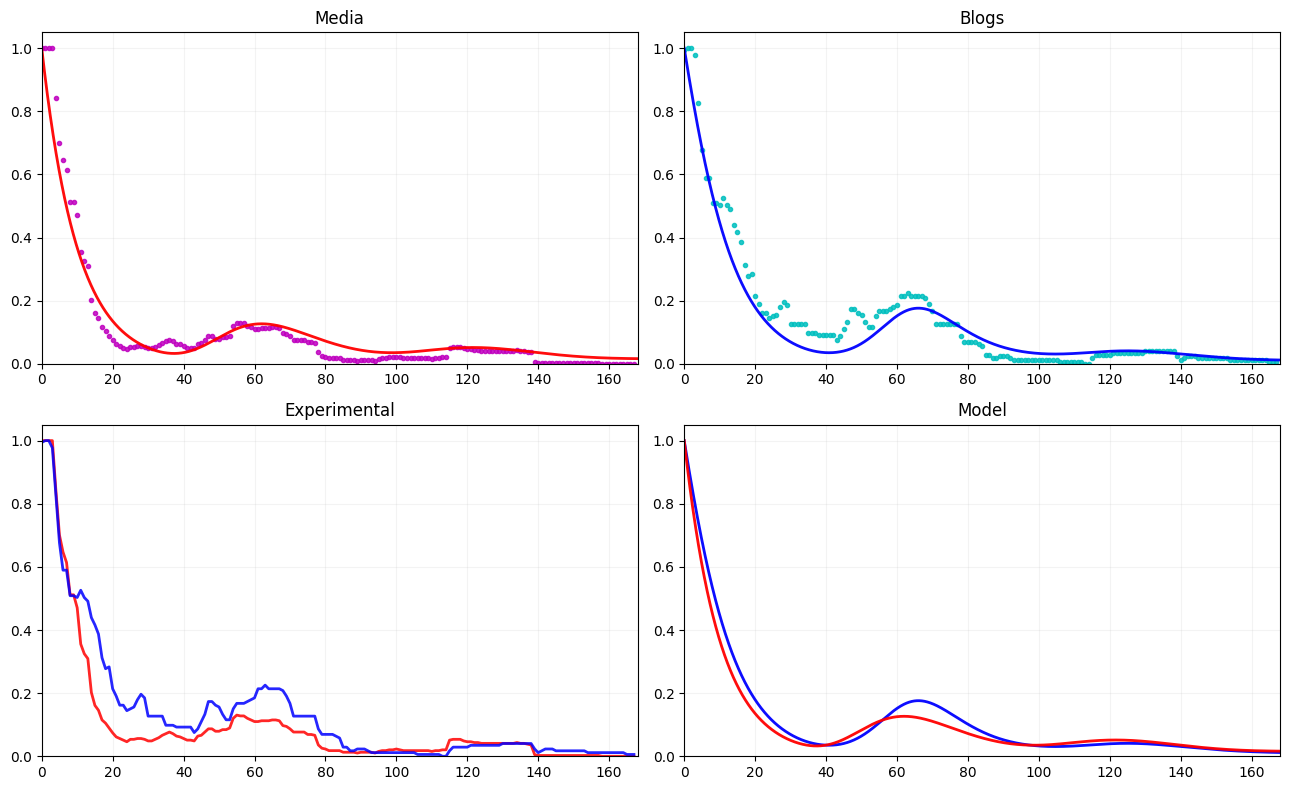

In [103]:
fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize = (13,8), dpi = 100)
ax.plot(data.media.to_numpy(), '.', color = 'm', linewidth = 2, label = 'media', alpha = 0.85)
ax.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95)
ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])
ax.grid(True, alpha = 0.15)
ax.set_title('Media')

ax2.plot(data.blog.to_numpy(), '.', color = 'c', linewidth = 2, label = 'blog', alpha = 0.85)
ax2.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95)
ax2.set_ylim([0.00, 1.05])
ax2.set_xlim([0, data.shape[0]])
ax2.grid(True, alpha = 0.15)
ax2.set_title('Blogs')

ax3.plot(data.media.to_numpy(), '-', color = 'r', linewidth = 2, label = 'media', alpha = 0.85)
ax3.plot(data.blog.to_numpy(), '-', color = 'b', linewidth = 2, label = 'blog', alpha = 0.85)

ax3.set_ylim([0.00, 1.05])
ax3.set_xlim([0, data.shape[0]])
ax3.grid(True, alpha = 0.15)
ax3.set_title('Experimental')

ax4.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95)
ax4.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95)

ax4.set_ylim([0.00, 1.05])
ax4.set_xlim([0, data.shape[0]])
ax4.grid(True, alpha = 0.15)
ax4.set_title('Model')

fig.tight_layout()


plt.show()

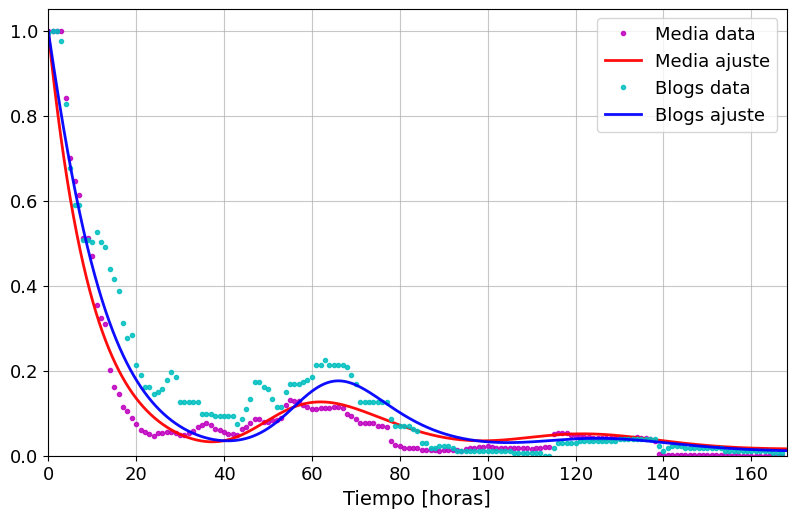

In [105]:
# Figures

fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (8,5), dpi = 100)
ax.plot(data.media.to_numpy(), '.', color = 'm', linewidth = 2, label = 'Media data', alpha = 0.85)
ax.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95, label = 'Media ajuste')
ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])
ax.grid(True, alpha = 0.15)
#ax.set_title('Media')

ax.plot(data.blog.to_numpy(), '.', color = 'c', linewidth = 2, label = 'Blogs data', alpha = 0.85)
ax.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95, label = 'Blogs ajuste')
ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])
ax.grid(True, alpha = 0.15)
#ax.set_title(citas[index]+ '\nTw y RT')

fig.tight_layout()
plt.legend(fontsize = 13)
plt.grid(alpha = 0.7)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel('Tiempo [horas]', fontsize = 14)
#plt.savefig('d:/Facultad/Tesis/Escritura/Ajuste/double_bump_a_ojo_leskovec.pdf')
plt.show()

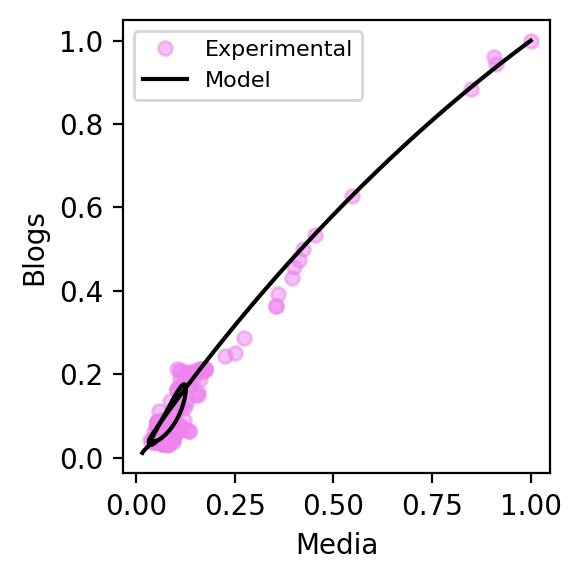

In [88]:
# Phase diagram

plt.figure(figsize = (3,3), dpi = 200)
plt.plot(data.media.to_numpy(), data.blog.to_numpy(), '.', markersize = 10, alpha = 0.50, color = 'violet', label = 'Experimental')
plt.plot(yy[:,0], yy[:,1], color = 'k', label = 'Model')
plt.xlabel('Media')
plt.ylabel('Blogs')
plt.legend(loc = 'best', fontsize = 8)
plt.tight_layout()
plt.show()

### Parameter fitting

In [89]:
def function2minimize(all_coeffs, data, ngammas):

    coeffs = all_coeffs[:(len(all_coeffs) - 2)]

    x0 = all_coeffs[-2:]
    x0 = list(x0) + [0.00]*ngammas

    tt, yy = integrate_model(coeffs, data.shape[0], x0)

    media_integrated = yy[tt % 1 == 0][:data.shape[0], 0]
    blog_integrated = yy[tt % 1 == 0][:data.shape[0], 1]

    error = (((media_integrated - data.media.to_numpy())**2) + ((blog_integrated - data.blog.to_numpy())**2))**0.5

    return np.mean(error)

In [90]:
function2minimize(coeffs + [1.00, 1.00], data, ngammas)

0.08170078809582515

In [91]:
lims = {'p': [0.001, 1],
            'alpha': [0.001, 1],
            'q': [0.001, 1],
            'r': [0.001, 1],
            'k': [-10.00, 10.00],
            'tau': [12, data.shape[0]-24],
            'm0': [0.75, 1.25],
            'b0': [0.75*data.blog.iloc[0], 1.25*data.blog.iloc[0]]}

lower_bounds = [l[0] for l in lims.values()]
upper_bounds = [l[1] for l in lims.values()]

bounds = Bounds(lower_bounds, upper_bounds)

In [92]:
popsize = 8
ngammas = 30
sol = differential_evolution(function2minimize, bounds=bounds, args=(data, ngammas),
                                 popsize=popsize, recombination = 0.30, mutation = (0.1, 1.9),
                                 updating='deferred', workers = 1, tol = 0.001,
                                 polish= False, disp = True, maxiter = 200, x0 = start_params + [1.00, data.blog[0]])

C:\Users\Ale\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


differential_evolution step 1: f(x)= 0.0817008
differential_evolution step 2: f(x)= 0.0817008
differential_evolution step 3: f(x)= 0.0817008
differential_evolution step 4: f(x)= 0.0817008
differential_evolution step 5: f(x)= 0.0817008
differential_evolution step 6: f(x)= 0.0817008
differential_evolution step 7: f(x)= 0.0817008
differential_evolution step 8: f(x)= 0.0817008
differential_evolution step 9: f(x)= 0.0817008
differential_evolution step 10: f(x)= 0.0673839
differential_evolution step 11: f(x)= 0.0673839
differential_evolution step 12: f(x)= 0.0673839
differential_evolution step 13: f(x)= 0.0673839
differential_evolution step 14: f(x)= 0.0673839
differential_evolution step 15: f(x)= 0.0673839
differential_evolution step 16: f(x)= 0.0673839
differential_evolution step 17: f(x)= 0.0673839
differential_evolution step 18: f(x)= 0.0673839
differential_evolution step 19: f(x)= 0.0673839
differential_evolution step 20: f(x)= 0.0673839
differential_evolution step 21: f(x)= 0.0673839
d

C:\Users\Ale\AppData\Local\Temp\ipykernel_18100\267523000.py:13: RuntimeWarning: overflow encountered in square
  error = (((media_integrated - data.media.to_numpy())**2) + ((blog_integrated - data.blog.to_numpy())**2))**0.5


differential_evolution step 189: f(x)= 0.0447928
differential_evolution step 190: f(x)= 0.0447928
differential_evolution step 191: f(x)= 0.0447928
differential_evolution step 192: f(x)= 0.0447928
differential_evolution step 193: f(x)= 0.0447928
differential_evolution step 194: f(x)= 0.0447928
differential_evolution step 195: f(x)= 0.0442159
differential_evolution step 196: f(x)= 0.0442159
differential_evolution step 197: f(x)= 0.0442159
differential_evolution step 198: f(x)= 0.0442159
differential_evolution step 199: f(x)= 0.0442159
differential_evolution step 200: f(x)= 0.0442159


#### Result

In [93]:
sol

 message: Maximum number of iterations has been exceeded.
 success: False
     fun: 0.04421587566062717
       x: [ 7.307e-02  5.653e-02  2.058e-01  1.330e-01  5.121e-01
            7.922e+01  7.527e-01  9.700e-01]
     nit: 200
    nfev: 12864

In [94]:
# Integration of the model with final parameters
coeffs = sol.x[:len(sol.x)-2]
x0 = list(sol.x[-2:]) + [0.00] * ngammas

tt, yy = integrate_model(coeffs, data.shape[0], x0)

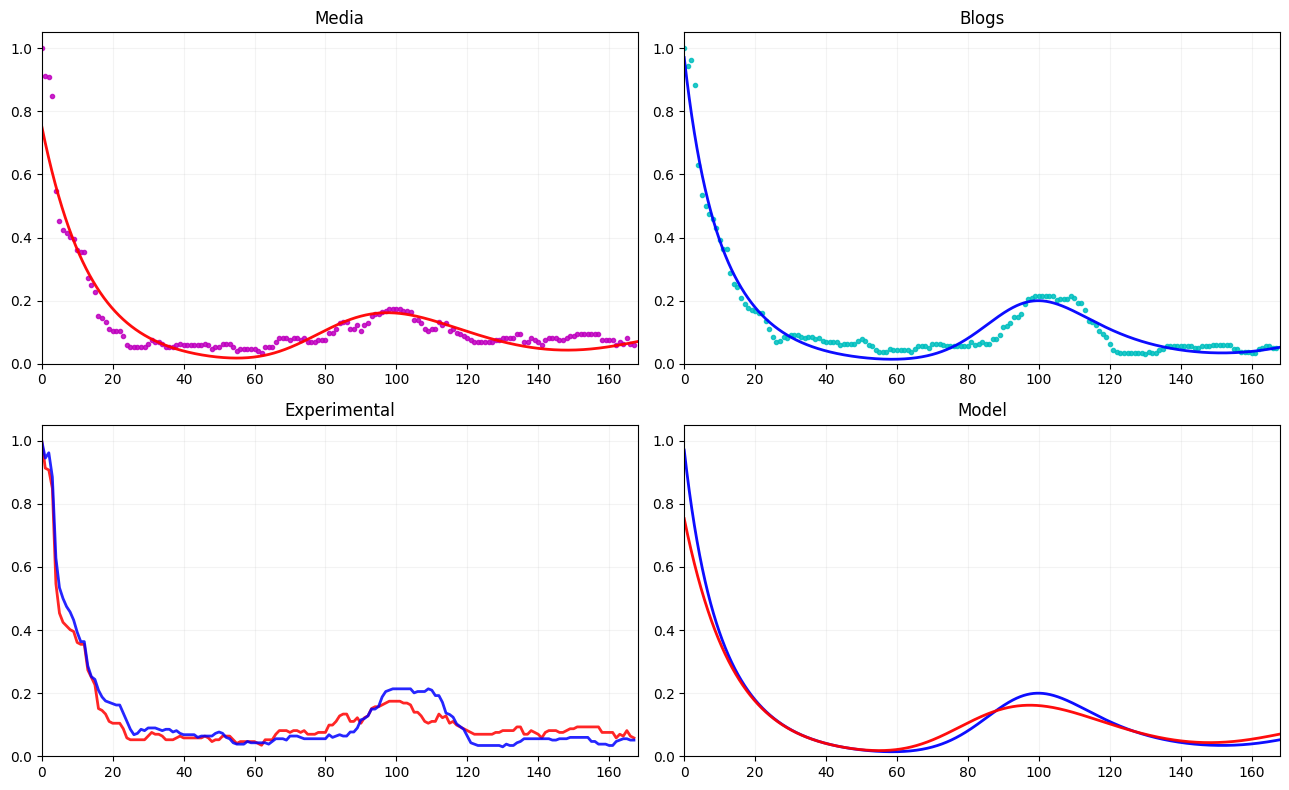

In [95]:
# Figures

fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize = (13,8), dpi = 100)
ax.plot(data.media.to_numpy(), '.', color = 'm', linewidth = 2, label = 'media', alpha = 0.85)
ax.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95)
ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])
ax.grid(True, alpha = 0.15)
ax.set_title('Media')

ax2.plot(data.blog.to_numpy(), '.', color = 'c', linewidth = 2, label = 'blog', alpha = 0.85)
ax2.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95)
ax2.set_ylim([0.00, 1.05])
ax2.set_xlim([0, data.shape[0]])
ax2.grid(True, alpha = 0.15)
ax2.set_title('Blogs')

ax3.plot(data.media.to_numpy(), '-', color = 'r', linewidth = 2, label = 'media', alpha = 0.85)
ax3.plot(data.blog.to_numpy(), '-', color = 'b', linewidth = 2, label = 'blog', alpha = 0.85)

ax3.set_ylim([0.00, 1.05])
ax3.set_xlim([0, data.shape[0]])
ax3.grid(True, alpha = 0.15)
ax3.set_title('Experimental')

ax4.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95)
ax4.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95)

ax4.set_ylim([0.00, 1.05])
ax4.set_xlim([0, data.shape[0]])
ax4.grid(True, alpha = 0.15)
ax4.set_title('Model')

fig.tight_layout()

plt.show()

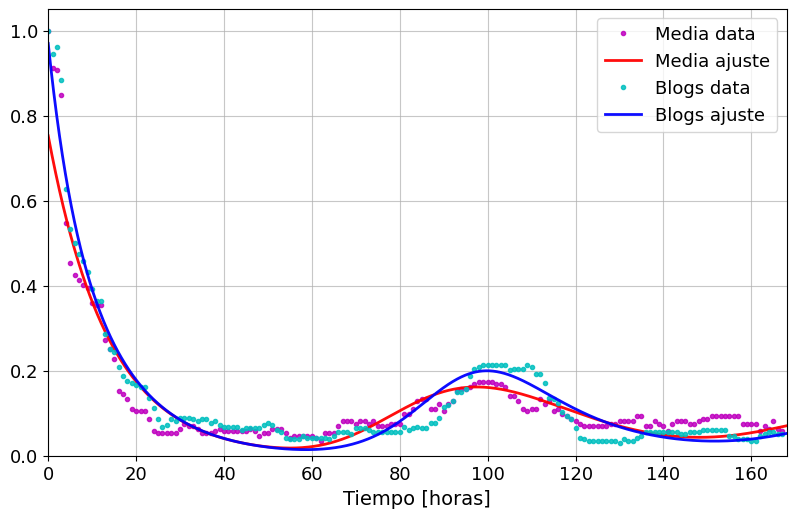

In [97]:
# Figures

fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (8,5), dpi = 100)
ax.plot(data.media.to_numpy(), '.', color = 'm', linewidth = 2, label = 'Media data', alpha = 0.85)
ax.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.95, label = 'Media ajuste')
ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])
ax.grid(True, alpha = 0.15)
#ax.set_title('Media')

ax.plot(data.blog.to_numpy(), '.', color = 'c', linewidth = 2, label = 'Blogs data', alpha = 0.85)
ax.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.95, label = 'Blogs ajuste')
ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])
ax.grid(True, alpha = 0.15)
#ax.set_title(citas[index]+ '\nTw y RT')

fig.tight_layout()
plt.legend(fontsize = 13)
plt.grid(alpha = 0.7)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel('Tiempo [horas]', fontsize = 14)
plt.savefig('d:/Facultad/Tesis/Escritura/Ajuste/ambos_bump_lkvoc.pdf')

plt.show()

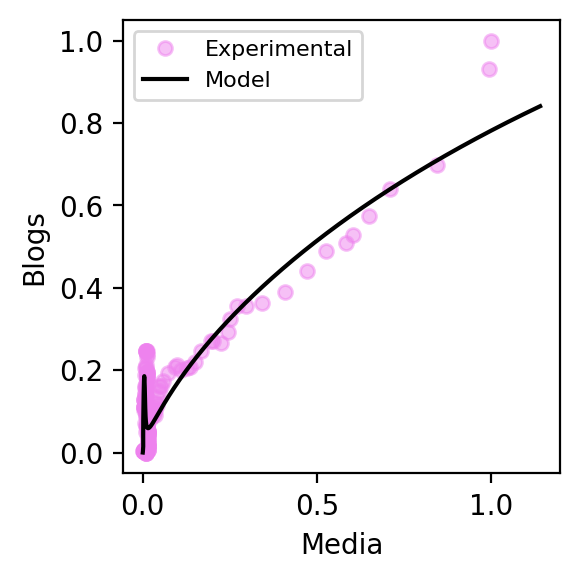

In [ ]:
# Phase diagram

plt.figure(figsize = (3,3), dpi = 200)
plt.plot(data.media.to_numpy(), data.blog.to_numpy(), '.', markersize = 10, alpha = 0.50, color = 'violet', label = 'Experimental')
plt.plot(yy[:,0], yy[:,1], color = 'k', label = 'Model')
plt.xlabel('Media')
plt.ylabel('Blogs')
plt.legend(loc = 'best', fontsize = 8)
plt.tight_layout()
plt.show()